In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import hist, processor
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

/work/dvalsecc/miniconda3/envs/pocket-coffea/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/RunIIFall17NanoAODv7/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/587E2464-42CA-3A45-BD49-D23E49F658E6.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=400000).events()

In [3]:
events.Jet.rawFactor

<Array [[0.0635, 0.04, ... -0.00543, -0.664]] type='400000 * var * float32[param...'>

In [4]:
SF = ak.flatten(1 - events.Jet.rawFactor)
SF

<Array [0.937, 0.96, 0.958, ... 1.01, 1.66] type='4343693 * float32'>

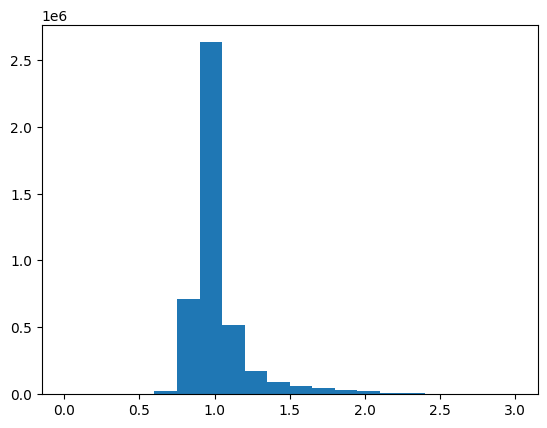

In [11]:
plt.hist(SF, bins=20, range=(0,3));

In [12]:
pt_raw = (1 - events.Jet['rawFactor']) * events.Jet['pt']

In [13]:
ratio = ak.flatten(events.Jet.pt/pt_raw)
ratio

<Array [1.07, 1.04, 1.04, ... 0.995, 0.601] type='4343693 * float32'>

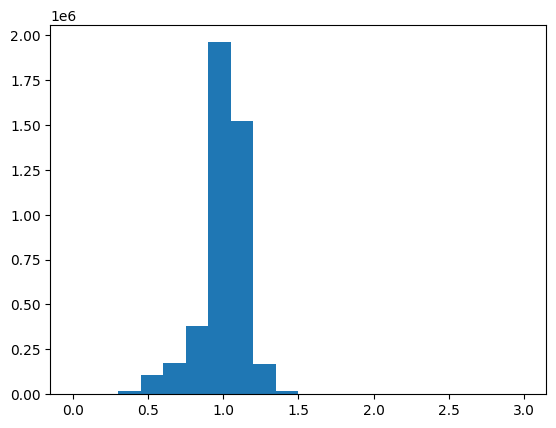

In [14]:
plt.hist(ratio, bins=20, range=(0,3));

(array([0.000000e+00, 0.000000e+00, 0.000000e+00, 2.050000e+02,
        2.136400e+04, 7.107010e+05, 2.630348e+06, 5.204000e+05,
        1.720750e+05, 9.079700e+04, 6.480300e+04, 4.666500e+04,
        3.338600e+04, 2.284300e+04, 1.320600e+04, 8.632000e+03,
        4.469000e+03, 1.948000e+03, 1.068000e+03, 5.150000e+02]),
 array([0.        , 0.15000001, 0.30000001, 0.44999999, 0.60000002,
        0.75      , 0.89999998, 1.04999995, 1.20000005, 1.35000002,
        1.5       , 1.64999998, 1.79999995, 1.95000005, 2.0999999 ,
        2.25      , 2.4000001 , 2.54999995, 2.70000005, 2.8499999 ,
        3.        ]),
 <BarContainer object of 20 artists>)

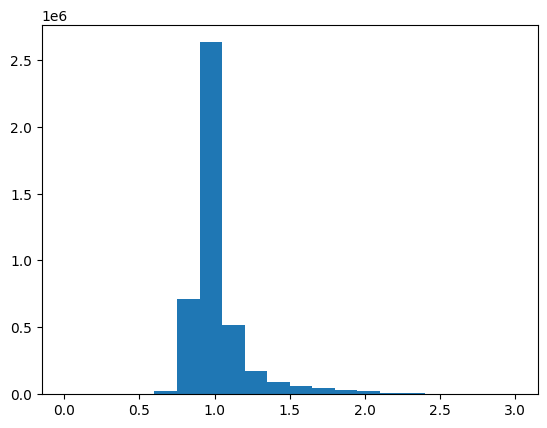

In [9]:
plt.hist(1/ratio, bins=20, range=(0,3))

# Testing the coffea implementation

In [15]:
import gzip

import cloudpickle

In [20]:
path = "../pocket_coffea/parameters/jec/jets_evaluator.pkl.gz"

In [21]:
with gzip.open(path) as fin:
        jmestuff = cloudpickle.load(fin)

/tmp/ipykernel_61658/3306577911.py:2: DeprecationWarning: Please use `interp1d` from the `scipy.interpolate` namespace, the `scipy.interpolate.interpolate` namespace is deprecated.
  jmestuff = cloudpickle.load(fin)


In [22]:
def add_jec_variables(jets, event_rho):
    jets["pt_raw"] = (1 - jets.rawFactor)*jets.pt
    jets["mass_raw"] = (1 - jets.rawFactor)*jets.mass
    jets["pt_gen"] = ak.values_astype(ak.fill_none(jets.matched_gen.pt, 0), np.float32)
    jets["event_rho"] = ak.broadcast_arrays(event_rho, jets.pt)[0]
    return jets


In [25]:
jmestuff

{'jet_factory': {'2016_PreVFP': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x7fe15e376eb0>,
  '2016_PreVFP_NOJER': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x7fe37c5f0100>,
  '2017': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x7fe361d32940>,
  '2017_NOJER': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x7fe36182d940>,
  '2017_NOJESunc': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x7fe3613a6eb0>,
  '2018': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x7fe36136f4f0>,
  '2018_NOJER': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x7fe360ed57f0>,
  '2018_NOJESunc': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x7fe3609dc100>},
 'fatjet_factory': {'2016_PreVFP': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x7fe3609f4a60>,
  '2016_PreVFP_NOJER': <coffea.jetmet_tools.CorrectedJetsFactory.Correct

In [23]:
import cachetools
jec_cache = cachetools.Cache(np.inf)

In [26]:
%%time
j = jmestuff["jet_factory"]["2018"].build(add_jec_variables(events.Jet,events.fixedGridRhoFastjetAll), jec_cache)
jr = jmestuff["jet_factory"]["2018_NOJER"].build(add_jec_variables(events.Jet,events.fixedGridRhoFastjetAll), jec_cache)

CPU times: user 1.17 s, sys: 496 ms, total: 1.67 s
Wall time: 1.66 s


In [27]:
[f for f in jr.fields if "JER" in f]

[]

In [28]:
[f for f in jr.fields if "JES" in f]

['JES_FlavorQCD',
 'JES_RelativeBal',
 'JES_HF',
 'JES_BBEC1',
 'JES_EC2',
 'JES_Absolute',
 'JES_Absolute_2018',
 'JES_HF_2018',
 'JES_EC2_2018',
 'JES_RelativeSample_2018',
 'JES_BBEC1_2018',
 'JES_Total']

In [18]:
%%time
j.JES_HF_2018.up.pt

CPU times: user 1.32 ms, sys: 280 µs, total: 1.6 ms
Wall time: 1.63 ms


<Array [[178, 94, 75.9, ... 22.2, 25, 23.4]] type='400000 * var * float32'>

In [19]:
j.JER.fields

['up', 'down']

AttributeError: no field named 'JER'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/awkward/highlevel.py#L1124)

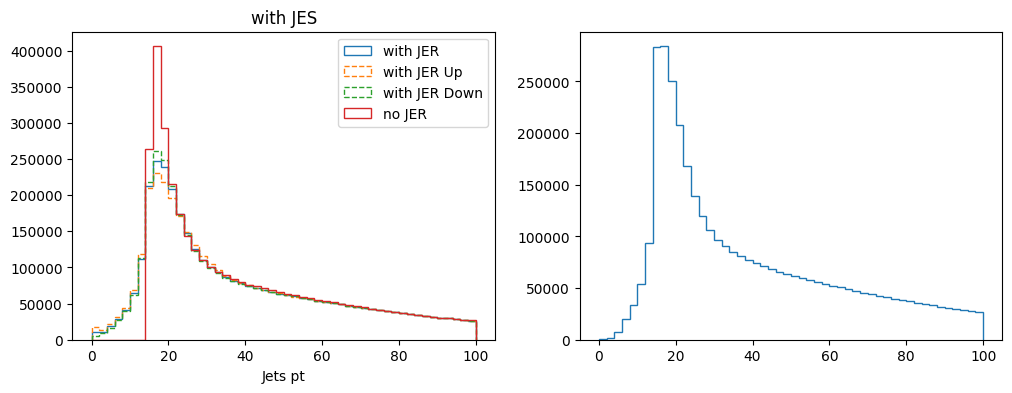

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,4])
ax1.hist(ak.flatten(j.pt), bins=50, range=(0,100), histtype="step", label="with JER")
ax1.hist(ak.flatten(j.JER.up.pt), bins=50, range=(0,100), histtype="step", label="with JER Up", linestyle='dashed')
ax1.hist(ak.flatten(j.JER.down.pt), bins=50, range=(0,100), histtype="step", label="with JER Down", linestyle='dashed')
ax1.hist(ak.flatten(events.Jet.pt), bins=50, range=(0,100), histtype="step",label="no JER")
ax1.legend()
ax1.set_title("with JES")
ax1.set_xlabel("Jets pt")

ax2.hist(ak.flatten(jr.pt), bins=50, range=(0,100), histtype="step", label="with JER")
ax2.hist(ak.flatten(jr.JER.up.pt), bins=50, range=(0,100), histtype="step", label="with JER Up", linestyle='dashed')
ax2.hist(ak.flatten(jr.JER.down.pt), bins=50, range=(0,100), histtype="step", label="with JER Down", linestyle='dashed')
ax2.hist(ak.flatten(events.Jet.pt), bins=50, range=(0,100), histtype="step",label="no JER")
ax2.legend()
ax2.set_title("NO JES")
ax2.set_xlabel("Jets pt")

(array([ 11039.,  13818.,  24235.,  36152.,  49853.,  78287., 149886.,
        247230., 255970., 229251., 192016., 160199., 136065., 118373.,
        106003.,  97323.,  90028.,  84248.,  80024.,  76970.,  73153.,
         70420.,  68014.,  65194.,  62913.,  61074.,  58959.,  57185.,
         55294.,  53046.,  51664.,  49842.,  47987.,  46388.,  45223.,
         43309.,  41689.,  40407.,  38796.,  37766.,  36062.,  34896.,
         34008.,  32544.,  31003.,  29933.,  29405.,  27789.,  26699.,
         25998.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 [<matplotlib.patches.Polygon at 0x7fe35e00df40>])

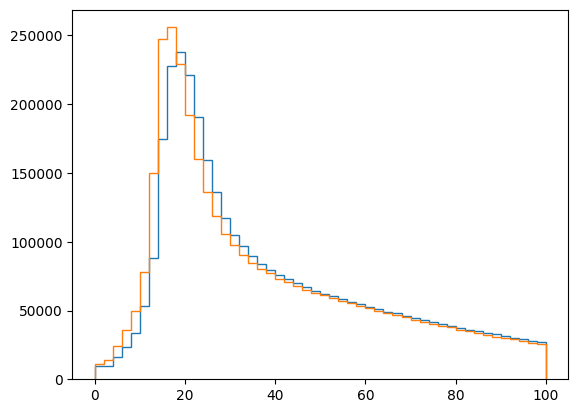

In [30]:
plt.hist(ak.flatten(j.JES_jes.up.pt), bins=50, range=(0,100), histtype="step")
plt.hist(ak.flatten(j.JES_jes.down.pt), bins=50, range=(0,100), histtype="step")

(array([  9419.,   9520.,  15891.,  23578.,  33505.,  53124.,  88488.,
        175039., 227541., 237822., 221191., 190696., 159588., 135980.,
        117390., 104570.,  96696.,  89866.,  83739.,  79227.,  75878.,
         72617.,  69942.,  66763.,  64502.,  62184.,  60499.,  58119.,
         56514.,  54766.,  52686.,  51045.,  49051.,  47998.,  46238.,
         44772.,  43138.,  41647.,  40153.,  38745.,  37402.,  36196.,
         34923.,  33923.,  32695.,  31263.,  30054.,  29398.,  27819.,
         27141.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 [<matplotlib.patches.Polygon at 0x7fd196ebd5e0>])

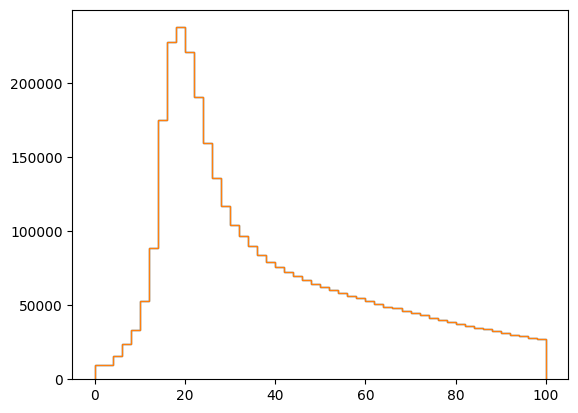

In [22]:
plt.hist(ak.flatten(j.JES_Total.up.pt), bins=50, range=(0,100), histtype="step")
plt.hist(ak.flatten(j.JES_jes.up.pt), bins=50, range=(0,100), histtype="step")

In [23]:
events["Jet"] = j.JES_jes.up

(array([  9419.,   9520.,  15891.,  23578.,  33505.,  53124.,  88488.,
        175039., 227541., 237822., 221191., 190696., 159588., 135980.,
        117390., 104570.,  96696.,  89866.,  83739.,  79227.,  75878.,
         72617.,  69942.,  66763.,  64502.,  62184.,  60499.,  58119.,
         56514.,  54766.,  52686.,  51045.,  49051.,  47998.,  46238.,
         44772.,  43138.,  41647.,  40153.,  38745.,  37402.,  36196.,
         34923.,  33923.,  32695.,  31263.,  30054.,  29398.,  27819.,
         27141.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 [<matplotlib.patches.Polygon at 0x7fd196c0b1c0>])

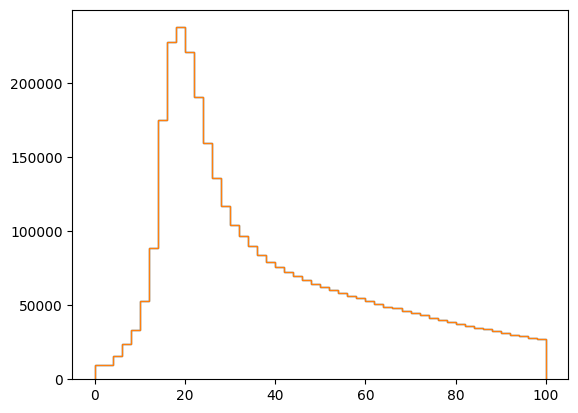

In [24]:
plt.hist(ak.flatten(j.JES_jes.up.pt), bins=50, range=(0,100), histtype="step")
plt.hist(ak.flatten(events.Jet.pt), bins=50, range=(0,100), histtype="step")

# PocketCoffea integration

In [31]:
nominal_events = events

In [32]:
id(nominal_events)

140605926222864

In [33]:
id(events)

140605926222864